In [1]:
%matplotlib inline

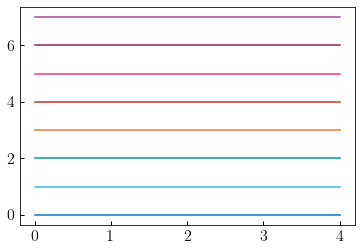

In [43]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap
from jax import grad
from jax import random as jran
import os
import h5py
import time

mred = u"#d62728"
morange = u"#ff7f0e"
mgreen = u"#2ca02c"
mblue = u"#1f77b4"
mpurple = u"#9467bd"
plt.rc('font', family="serif")
plt.rc('font', size=22)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']
for i, x in enumerate(colors):
    plt.plot(np.ones(5)*i, color=x)

# Define some basic quantities

In [8]:
from diffstar.constants import TODAY
from diffstar.stars import fstar_tools

# Define our cosmci time array to make some predictions
#t_table = np.linspace(0.1, TODAY, 100)
t_table = np.logspace(-1, np.log10(TODAY), 100)



# Define some mass bins for predictions
logm0_binmids = np.linspace(11.5, 13.5, 3)
logm0_bin_widths = np.ones_like(logm0_binmids) * 0.1


# Define some useful quantities and masks for later
fstar_tdelay = 1.0
index_select, index_high = fstar_tools(t_table, fstar_tdelay=fstar_tdelay)


sm_loss_weight = jnp.where(t_table>2.0, 1.0, 1e10)
fstar_loss_MS_weight = jnp.where(t_table[index_select]>2.0, 1.0, 1e10)
fstar_loss_Q_weight = jnp.where(t_table[index_select]>5.0, 1.0, 1e10)

sm_loss_sel = np.arange(len(t_table))[t_table>1.0]
fstar_loss_MS_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>2.0]
fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>5.0]


# Generate some individual MAH histories with DiffmahPop

In [14]:
from diffmah.monte_carlo_halo_population import mc_halo_population
from diffstarpop.utils import get_t50_p50

N = 20
logmpeak_diffmahpop = []
mah_params_diffmahpop = []

log_mahs = np.zeros((len(logm0_binmids), N, len(t_table)))
for i, binmid in enumerate(logm0_binmids):
    _res = mc_halo_population(t_table, TODAY, binmid * np.ones(N))
    _mahparams = np.array([
        np.ones(N)*np.log10(TODAY),
        binmid * np.ones(N),
        _res.lgtc,
        np.ones(N)*3.5,
        _res.early_index,
        _res.late_index,
    ]).T
    
    logmpeak_diffmahpop.append(binmid * np.ones(N))
    mah_params_diffmahpop.append(_mahparams)
    
    log_mahs[i] = _res.log_mah
    

    
logmpeak_diffmahpop = np.concatenate(logmpeak_diffmahpop)
mah_params_diffmahpop = np.concatenate(mah_params_diffmahpop)
log_mahs_diffmahpop = np.concatenate(log_mahs)

halo_data_MC = mah_params_diffmahpop[:, np.array([1,2,4,5])].copy() # We only need logm, logtauc, early, late

t50, p50 = get_t50_p50(t_table, 10**log_mahs_diffmahpop, 0.5, log_mahs_diffmahpop[:,-1], window_length = 9)
#p50 = p50.reshape((len(logm0_binmids), N))



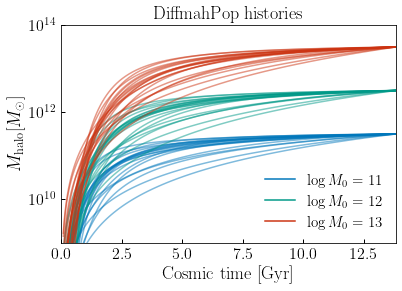

In [15]:
fig, ax = plt.subplots()

ax.plot(t_table, 10**log_mahs[0].T, colors[0], alpha=0.5)
ax.plot(t_table, 10**log_mahs[1].T, colors[2], alpha=0.5)
ax.plot(t_table, 10**log_mahs[2].T, colors[4], alpha=0.5)
ax.set_yscale('log')
ax.set_ylim(1e9, 1e14)
ax.set_xlim(0, TODAY)
ax.set_xlabel('Cosmic time [Gyr]')
ax.set_ylabel(r'$M_{\rm halo} [M_\odot]$')
ax.set_title("DiffmahPop histories")

legend_elements = [
    Line2D([0], [0], color=colors[0], label=r'$\log M_0 = %d$'%logm0_binmids[0]),
    Line2D([0], [0], color=colors[2], label=r'$\log M_0 = %d$'%logm0_binmids[1]),
    Line2D([0], [0], color=colors[4], label=r'$\log M_0 = %d$'%logm0_binmids[2]),
]
ax.legend(handles=legend_elements, loc=0)

plt.show()

### Get the default DiffstarPOP parameters for quenched and main sequence populations

In [16]:
from diffstarpop.pdf_quenched import DEFAULT_SFH_PDF_QUENCH_PARAMS
from diffstarpop.pdf_mainseq import DEFAULT_SFH_PDF_MAINSEQ_PARAMS

DEFAULT_SFH_PDF_QUENCH_PARAMS, DEFAULT_SFH_PDF_MAINSEQ_PARAMS

(OrderedDict([('frac_quench_x0', 12.06),
              ('frac_quench_k', 1.27),
              ('frac_quench_ylo', -0.81),
              ('frac_quench_yhi', 1.78),
              ('mean_ulgm_quench_ylo', 11.75),
              ('mean_ulgm_quench_yhi', 12.32),
              ('mean_ulgy_quench_ylo', 0.96),
              ('mean_ulgy_quench_yhi', -0.63),
              ('mean_ul_quench_ylo', -2.23),
              ('mean_ul_quench_yhi', 2.48),
              ('mean_utau_quench_ylo', 23.2),
              ('mean_utau_quench_yhi', -21.89),
              ('mean_uqt_quench_ylo', 1.67),
              ('mean_uqt_quench_yhi', -0.01),
              ('mean_uqs_quench_ylo', -3.61),
              ('mean_uqs_quench_yhi', 4.13),
              ('mean_udrop_quench_ylo', 0.33),
              ('mean_udrop_quench_yhi', -5.13),
              ('mean_urej_quench_ylo', 1.24),
              ('mean_urej_quench_yhi', -3.41),
              ('cov_ulgm_ulgm_quench_ylo', -0.12),
              ('cov_ulgm_ulgm_quench_yhi', -0.

### Get the default DiffstarPOP assembly bias parameters

In [17]:
from diffstarpop.pdf_model_assembly_bias_shifts import DEFAULT_R_MAINSEQ_PARAMS, DEFAULT_R_QUENCH_PARAMS

DEFAULT_R_MAINSEQ_PARAMS, DEFAULT_R_QUENCH_PARAMS

(OrderedDict([('R_ulgm_mainseq_ylo', -0.88),
              ('R_ulgm_mainseq_yhi', 0.99),
              ('R_ulgy_mainseq_ylo', 14.02),
              ('R_ulgy_mainseq_yhi', -26.44),
              ('R_ul_mainseq_ylo', -0.49),
              ('R_ul_mainseq_yhi', 6.91),
              ('R_utau_mainseq_ylo', 27.14),
              ('R_utau_mainseq_yhi', -47.65)]),
 OrderedDict([('R_ulgm_quench_ylo', -0.15),
              ('R_ulgm_quench_yhi', -0.36),
              ('R_ulgy_quench_ylo', -7.31),
              ('R_ulgy_quench_yhi', 8.04),
              ('R_ul_quench_ylo', -0.41),
              ('R_ul_quench_yhi', 2.44),
              ('R_utau_quench_ylo', 5.9),
              ('R_utau_quench_yhi', -8.93),
              ('R_uqt_quench_ylo', -0.03),
              ('R_uqt_quench_yhi', 0.41),
              ('R_uqs_quench_ylo', 7.86),
              ('R_uqs_quench_yhi', -10.64),
              ('R_udrop_quench_ylo', -4.83),
              ('R_udrop_quench_yhi', 6.61),
              ('R_urej_quench_ylo', 1.

# Draw individual SFH histories 


In [19]:
from diffstarpop.monte_carlo_diff_halo_population import (
    draw_sfh_Q_vmap,
    draw_sfh_MS_vmap,
    draw_sfh_MIX_vmap,
)


In [23]:
n_histories = int(1e3)
ran_key = jran.PRNGKey(0)

t0 = time.time()
histories = draw_sfh_MIX_vmap(
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(3,20,4),
    p50.reshape(3,20),
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    DEFAULT_SFH_PDF_QUENCH_PARAMS,
    DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    DEFAULT_R_QUENCH_PARAMS,
    DEFAULT_R_MAINSEQ_PARAMS,
)
t1 = time.time()
print(t1-t0)

0.27619385719299316


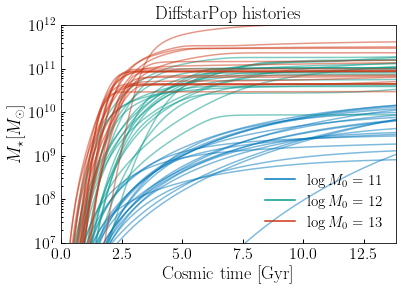

In [44]:
fig, ax = plt.subplots()

choice = np.random.choice(len(histories[0][0]), 20, replace=False)

ax.plot(t_table, histories[0][0][choice].T, colors[0], alpha=0.5)
ax.plot(t_table, histories[0][1][choice].T, colors[2], alpha=0.5)
ax.plot(t_table, histories[0][2][choice].T, colors[4], alpha=0.5)
ax.set_yscale('log')
ax.set_ylim(1e7, 1e12)
ax.set_xlim(0, TODAY)
ax.set_xlabel('Cosmic time [Gyr]')
ax.set_ylabel(r'$M_{\rm \star} [M_\odot]$')
ax.set_title("DiffstarPop histories")

legend_elements = [
    Line2D([0], [0], color=colors[0], label=r'$\log M_0 = %d$'%logm0_binmids[0]),
    Line2D([0], [0], color=colors[2], label=r'$\log M_0 = %d$'%logm0_binmids[1]),
    Line2D([0], [0], color=colors[4], label=r'$\log M_0 = %d$'%logm0_binmids[2]),
]
ax.legend(handles=legend_elements, loc=0)

plt.show()

# Calculate first and second order moments of Mstar, SFH with DiffstarPop drawing individual SFH histories


### Compare the calculations between two different `diffstar` kernel implementations using `vmap` or `scan` 

In [35]:
from diffstarpop.monte_carlo_diff_halo_population import (
    sumstats_sfh_Q_vmap,
    sumstats_sfh_MS_vmap,
    sumstats_sfh_MIX_vmap,
)


In [37]:
n_histories = int(1e3)
ran_key = jran.PRNGKey(0)

t0 = time.time()
MC_res_Q = sumstats_sfh_Q_vmap(
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(3,20,4),
    p50.reshape(3,20),
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    DEFAULT_SFH_PDF_QUENCH_PARAMS,
    DEFAULT_R_QUENCH_PARAMS,
)
t1 = time.time()
print(t1-t0)

t0 = time.time()
MC_res_MS = sumstats_sfh_MS_vmap(
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(3,20,4),
    p50.reshape(3,20),
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    DEFAULT_R_MAINSEQ_PARAMS,
)
t1 = time.time()
print(t1-t0)

t0 = time.time()
MC_res_MIX = sumstats_sfh_MIX_vmap(
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(3,20,4),
    p50.reshape(3,20),
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    DEFAULT_SFH_PDF_QUENCH_PARAMS,
    DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    DEFAULT_R_QUENCH_PARAMS,
    DEFAULT_R_MAINSEQ_PARAMS,
)
t1 = time.time()
print(t1-t0)

5.714577913284302
3.4331469535827637
6.356135129928589


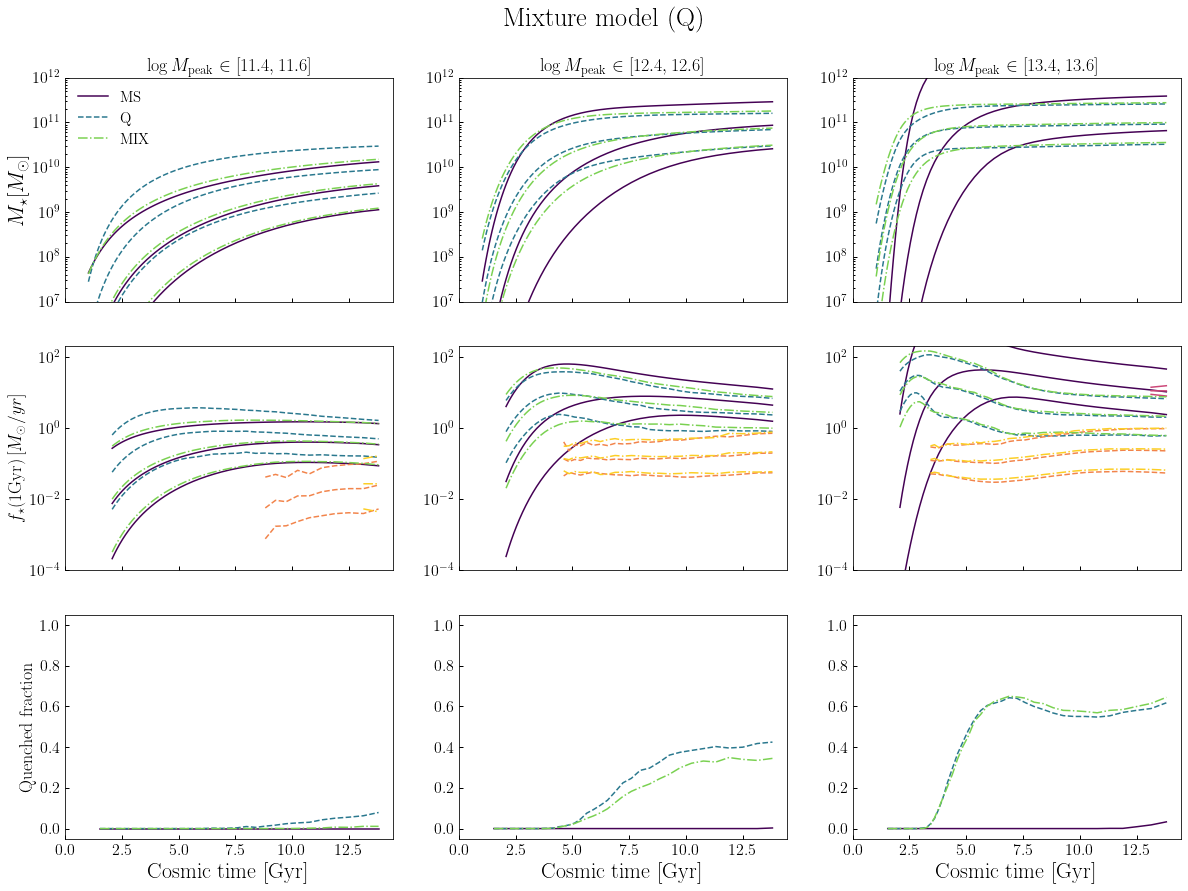

In [41]:
NM0 = len(logm0_binmids)

cmap = plt.get_cmap('viridis')
cmap2 = plt.get_cmap('plasma')
colors = [cmap(0.0), cmap(0.4), cmap(0.8), cmap2(0.5), cmap2(0.7), cmap2(0.9)]

fontsize=22
fig, ax = plt.subplots(3,NM0, figsize=(20,14), sharex=True, sharey=False)

for i in range(NM0):
    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**MC_res_MS[0][i][sm_loss_sel], ls="-", color=colors[0], label='MS')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(MC_res_MS[0][i]-np.sqrt(MC_res_MS[1][i]))[sm_loss_sel], ls="-", color=colors[0],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(MC_res_MS[0][i]+np.sqrt(MC_res_MS[1][i]))[sm_loss_sel], ls="-", color=colors[0],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**MC_res_MS[2][i][fstar_loss_MS_sel], ls="-", color=colors[0])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(MC_res_MS[2][i]-np.sqrt(MC_res_MS[4][i]))[fstar_loss_MS_sel], ls="-", color=colors[0],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(MC_res_MS[2][i]+np.sqrt(MC_res_MS[4][i]))[fstar_loss_MS_sel], ls="-", color=colors[0],)

    fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[(t_table[index_select]>fstar_tdelay)&(MC_res_MS[6][i]>0.01)]
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**MC_res_MS[3][i][fstar_loss_Q_sel], ls="-", color=colors[3])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(MC_res_MS[3][i]-np.sqrt(MC_res_MS[5][i]))[fstar_loss_Q_sel], ls="-", color=colors[3],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(MC_res_MS[3][i]+np.sqrt(MC_res_MS[5][i]))[fstar_loss_Q_sel], ls="-", color=colors[3],)

    ax[2,i].plot(t_table[index_select], MC_res_MS[6][i], ls="-", color=colors[0])
    
    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**MC_res_Q[0][i][sm_loss_sel], ls="--", color=colors[1], label='Q')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(MC_res_Q[0][i]-np.sqrt(MC_res_Q[1][i]))[sm_loss_sel], ls="--", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(MC_res_Q[0][i]+np.sqrt(MC_res_Q[1][i]))[sm_loss_sel], ls="--", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**MC_res_Q[2][i][fstar_loss_MS_sel], ls="--", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(MC_res_Q[2][i]-np.sqrt(MC_res_Q[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(MC_res_Q[2][i]+np.sqrt(MC_res_Q[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)

    fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[(t_table[index_select]>fstar_tdelay)&(MC_res_Q[6][i]>0.01)]
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**MC_res_Q[3][i][fstar_loss_Q_sel], ls="--", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(MC_res_Q[3][i]-np.sqrt(MC_res_Q[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(MC_res_Q[3][i]+np.sqrt(MC_res_Q[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)

    ax[2,i].plot(t_table[index_select], MC_res_Q[6][i], ls="--", color=colors[1])
    #"""

    ax[0,i].plot(t_table[sm_loss_sel], 10**MC_res_MIX[0][i][sm_loss_sel], ls="-.", color=colors[2], label='MIX')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(MC_res_MIX[0][i]-np.sqrt(MC_res_MIX[1][i]))[sm_loss_sel], ls="-.", color=colors[2],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(MC_res_MIX[0][i]+np.sqrt(MC_res_MIX[1][i]))[sm_loss_sel], ls="-.", color=colors[2],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**MC_res_MIX[2][i][fstar_loss_MS_sel], ls="-.", color=colors[2])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(MC_res_MIX[2][i]-np.sqrt(MC_res_MIX[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[2],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(MC_res_MIX[2][i]+np.sqrt(MC_res_MIX[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[2],)

    fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[(t_table[index_select]>fstar_tdelay)&(MC_res_MIX[6][i]>0.01)]
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**MC_res_MIX[3][i][fstar_loss_Q_sel], ls="-.", color=colors[5])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(MC_res_MIX[3][i]-np.sqrt(MC_res_MIX[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[5],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(MC_res_MIX[3][i]+np.sqrt(MC_res_MIX[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[5],)

    ax[2,i].plot(t_table[index_select], MC_res_MIX[6][i], ls="-.", color=colors[2])
    #"""
    
    
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 1e12)
    ax[1,i].set_ylim(1e-4, 2e2)
    ax[2,i].set_ylim(-0.05,1.05)
    ax[2,i].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,i].set_title(r'$\log M_{\rm peak}\in[%.1f, %.1f]$'%(logm0_binmids[i]-logm0_bin_widths[i], logm0_binmids[i]+logm0_bin_widths[i]))

ax[0,0].legend()
ax[1,0].legend()
ax[0,0].set_xticks(np.arange(0,13,2.5))
ax[0,0].set_ylabel('$M_\star [M_{\odot}]$', fontsize=fontsize)
ax[1,0].set_ylabel('$f_\star(1\mathrm{Gyr}) \,[M_{\odot}/yr]$')
ax[2,0].set_ylabel('Quenched fraction')
#fig.suptitle("Mixture model (Q+MS)", y=0.95)
fig.suptitle("Mixture model (Q)", y=0.95)
#fig.savefig('mc_vs_pdfweight_sumstats_p50_Q.png', bbox_inches='tight', dpi=300)
plt.show()